
# Overlay an AIA image on a LASCO C2 coronagraph

This example shows the steps needed to overlay the disc and off-limb
components of an AIA image within the masked occulter of a LASCO C2 image.


In [1]:
from datetime import datetime

import hvpy
import matplotlib.pyplot as plt
from hvpy.datasource import DataSource

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
from sunpy.coordinates import SphericalScreen
from sunpy.map import Map
from sunpy.util.config import get_and_create_download_dir

/home/kinno-7010/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we will acquire a calibrated LASCO C2 image from Helioviewer and
create a map. hvpy uses the standard datetime instead of astropy.time.



In [ ]:
lasco_jp2_file = hvpy.save_file(hvpy.getJP2Image(datetime(2011, 6, 7, 6, 34),
                                                 DataSource.LASCO_C2.value),
                                filename=get_and_create_download_dir() + "/LASCO_C2.jp2", overwrite=True)
lasco_map = Map(lasco_jp2_file)
aia_map = Map(sunpy.data.sample.AIA_171_IMAGE)

2025-01-31 19:10:36 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


2025-01-31 19:08:16 - reproject.common - INFO: Calling _reproject_full in non-dask mode


In order to plot off-limb features of the AIA image.

Note that off-disk AIA data are not retained by default because an
additional assumption is required to define the location of the AIA
emission in 3D space. We can use `~sunpy.coordinates.SphericalScreen` to
retain the off-disk AIA data. See
`sphx_glr_generated_gallery_map_transformations_reprojection_spherical_screen.py`
for more reference.



In [ ]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
# We use `~sunpy.coordinates.SphericalScreen` to ensure that the off limb AIA pixels
# are reprojected. Otherwise it will only be the on disk pixels that are reprojected.
with SphericalScreen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.util.logger]
2025-01-31 19:10:39 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs

2025-01-31 19:10:39 - reproject.common - INFO: Calling _reproject_full in non-dask mode


Finally, we plot the images by layering the AIA image on top of the LASCO C2
image.



2025-01-31 19:10:44 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


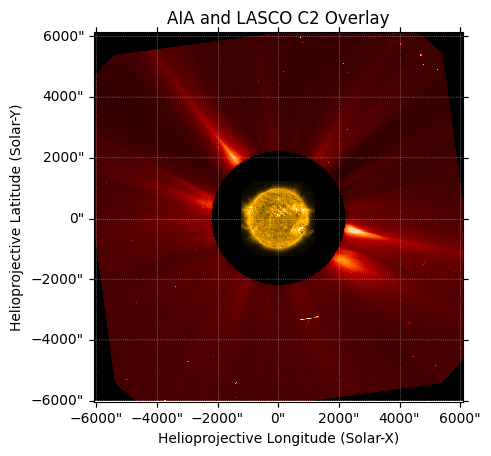

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
aia_reprojected.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)
ax.set_title("AIA and LASCO C2 Overlay")

plt.show()

### test

In [2]:
from datetime import datetime, timedelta

import hvpy
import matplotlib.pyplot as plt
from hvpy.datasource import DataSource

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import SphericalScreen
from sunpy.map import Map
from sunpy.net import Fido, attrs as a

def fetch_maps(date):
    """Fetches AIA and LASCO maps for a given date."""
    
    # Define search time range
    time_range = a.Time(date, date + timedelta(hours=2))
    
    # Query for AIA 193 Å and LASCO C2 data
    result = Fido.search(time_range, a.Instrument("AIA") & a.Wavelength(193*u.angstrom))
    aia_file = Fido.fetch(result[0, 0])
    aia_map = Map(aia_file)
    
    result = Fido.search(time_range, a.Instrument("LASCO") & a.Detector("C2"))
    lasco_file = Fido.fetch(result[0, 0])
    lasco_map = Map(lasco_file)
    
    return aia_map, lasco_map

# List of dates to plot
date_list = [datetime(2022, 6, 13)]

for date in date_list:
    aia_map, lasco_map = fetch_maps(date)
    
    projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                               obstime=lasco_map.observer_coordinate.obstime,
                               frame='helioprojective',
                               observer=lasco_map.observer_coordinate,
                               rsun=aia_map.coordinate_frame.rsun)
    projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                     projected_coord,
                                                     scale=u.Quantity(aia_map.scale),
                                                     instrument=aia_map.instrument,
                                                     wavelength=aia_map.wavelength)
    
    with SphericalScreen(aia_map.observer_coordinate):
        aia_reprojected = aia_map.reproject_to(projected_header)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection=lasco_map)
    lasco_map.plot(axes=ax)
    aia_reprojected.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)
    ax.set_title(f"AIA and LASCO C2 Overlay - {date.strftime('%Y-%m-%d')}")
    
    plt.show()


Files Downloaded: 100%|██████████| 1/1 [00:05<00:00,  5.33s/file]
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.util.logger]
2025-01-31 19:17:39 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,dsun_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs

2025-01-31 19:17:39 - reproject.common - INFO: Calling _reproject_full in non-dask mode


: 

### test-2

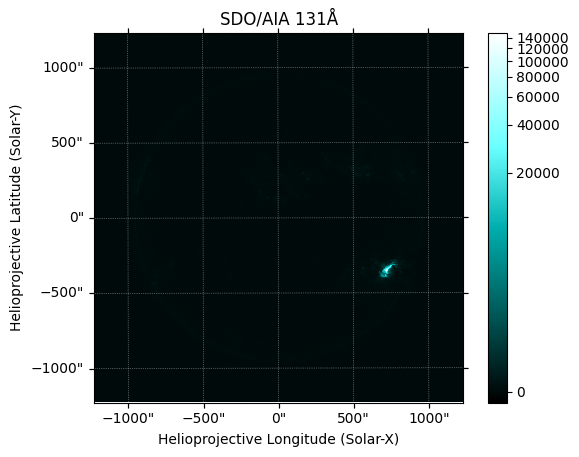

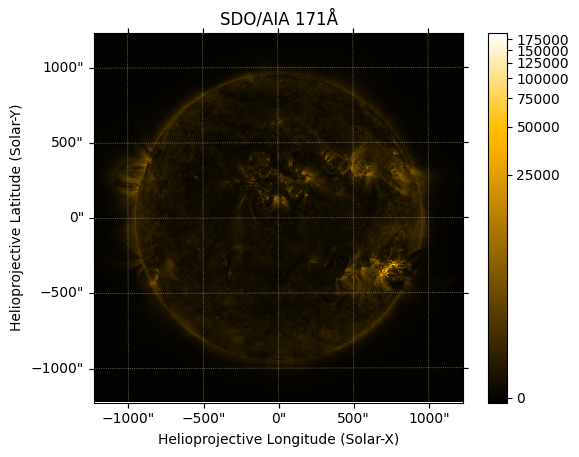

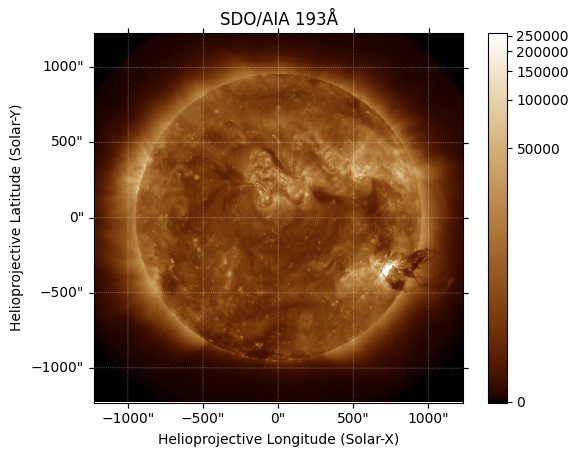

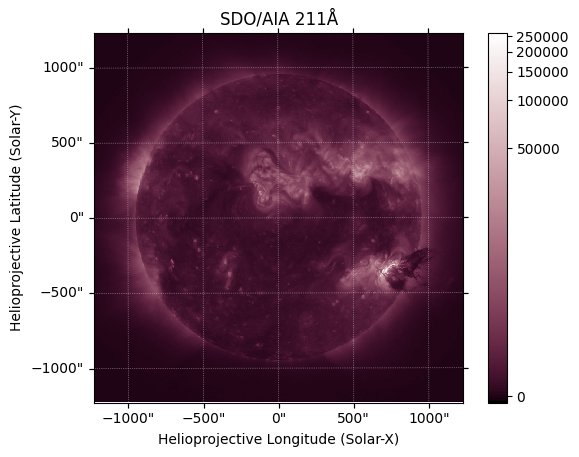

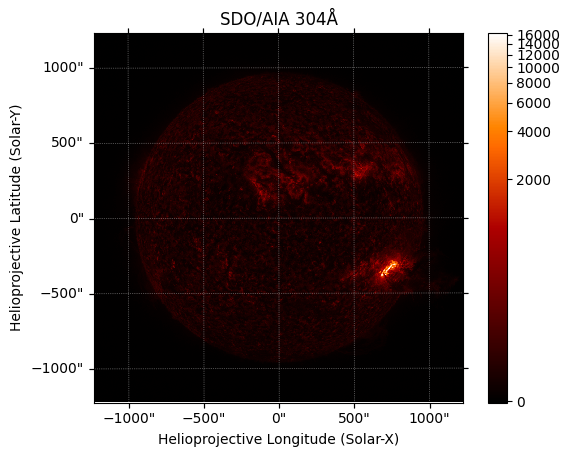

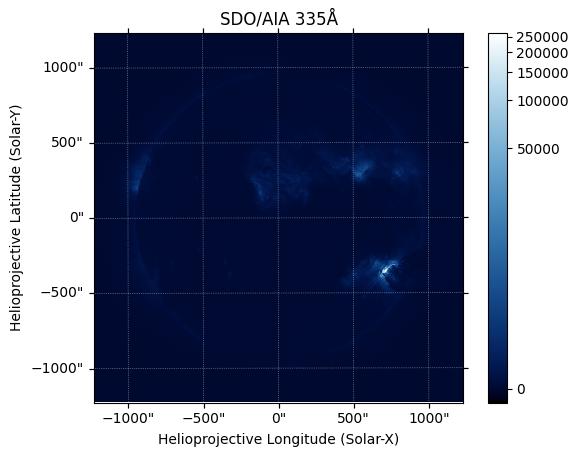

AttributeError: module 'sunpy.data.sample' has no attribute 'AIA_4500_IMAGE'

In [83]:


# # 94 Å (コロナ・活動領域)
# aia_94 = Map(sunpy.data.sample.AIA_94_IMAGE)
# aia_94.plot(cmap=cm.cmlist['sdoaia94'])
# plt.colorbar()
# plt.title("SDO/AIA 94Å")
# plt.show()

# 131 Å (コロナ・活動領域)
aia_131 = Map(sunpy.data.sample.AIA_131_IMAGE)
aia_131.plot(cmap=cm.cmlist['sdoaia131'])
plt.colorbar()
plt.title("SDO/AIA 131Å")
plt.show()

# 171 Å (コロナ)
aia_171 = Map(sunpy.data.sample.AIA_171_IMAGE)
aia_171.plot(cmap=cm.cmlist['sdoaia171'])
plt.colorbar()
plt.title("SDO/AIA 171Å")
plt.show()

# 193 Å (コロナ・ホットプラズマ)
aia_193 = Map(sunpy.data.sample.AIA_193_IMAGE)
aia_193.plot(cmap=cm.cmlist['sdoaia193'])
plt.colorbar()
plt.title("SDO/AIA 193Å")
plt.show()


# 211 Å (コロナ・活動領域)
aia_211 = Map(sunpy.data.sample.AIA_211_IMAGE)
aia_211.plot(cmap=cm.cmlist['sdoaia211'])
plt.colorbar()
plt.title("SDO/AIA 211Å")
plt.show()

# 304 Å (コロナ・活動領域)
aia_304 = Map(sunpy.data.sample.AIA_304_IMAGE)
aia_304.plot(cmap=cm.cmlist['sdoaia304'])
plt.colorbar()
plt.title("SDO/AIA 304Å")
plt.show()

# 335 Å (コロナ・活動領域)
aia_335 = Map(sunpy.data.sample.AIA_335_IMAGE)
aia_335.plot(cmap=cm.cmlist['sdoaia335'])
plt.colorbar()
plt.title("SDO/AIA 335Å")
plt.show()







# # 1600 Å (太陽表面)
# aia_1600 = Map(sunpy.data.sample.AIA_1600_IMAGE)
# aia_1600.plot(cmap=cm.cmlist['sdoaia1600'])
# plt.colorbar()
# plt.title("SDO/AIA 1600Å")
# plt.show()

# # 1700 Å (太陽表面)
# aia_1700 = Map(sunpy.data.sample.AIA_1700_IMAGE)
# aia_1700.plot(cmap=cm.cmlist['sdoaia1700'])
# plt.colorbar()
# plt.title("SDO/AIA 1700Å")
# plt.show()

# # 4500 Å (太陽表面)
# aia_4500 = Map(sunpy.data.sample.AIA_4500_IMAGE)
# aia_4500.plot(cmap=cm.cmlist['sdoaia4500'])
# plt.colorbar()
# plt.title("SDO/AIA 4500Å")
# plt.show()




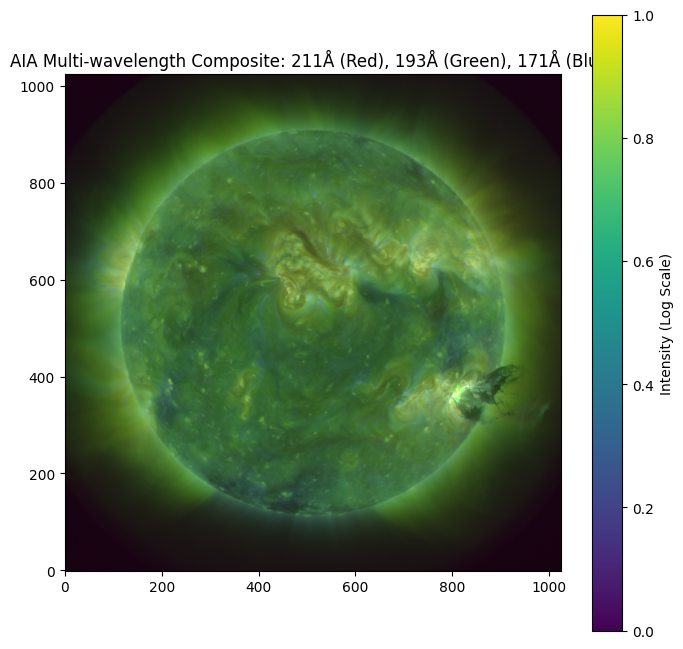

In [9]:
# 3つの波長を読み込む
aia_171 = Map(sunpy.data.sample.AIA_171_IMAGE)
aia_193 = Map(sunpy.data.sample.AIA_193_IMAGE)
aia_211 = Map(sunpy.data.sample.AIA_211_IMAGE)

# 正規化（対数スケールを使用）
def normalize(data):
    return vis.ImageNormalize(data, stretch=vis.LogStretch())

# 各波長を正規化
red_channel = normalize(aia_211.data)(aia_211.data)
green_channel = normalize(aia_193.data)(aia_193.data)
blue_channel = normalize(aia_171.data)(aia_171.data)

# RGB画像の作成 (3D NumPy配列)
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# プロット
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image, origin="lower")
plt.colorbar(label="Intensity (Log Scale)")
plt.title("AIA Multi-wavelength Composite: 211Å (Red), 193Å (Green), 171Å (Blue)")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


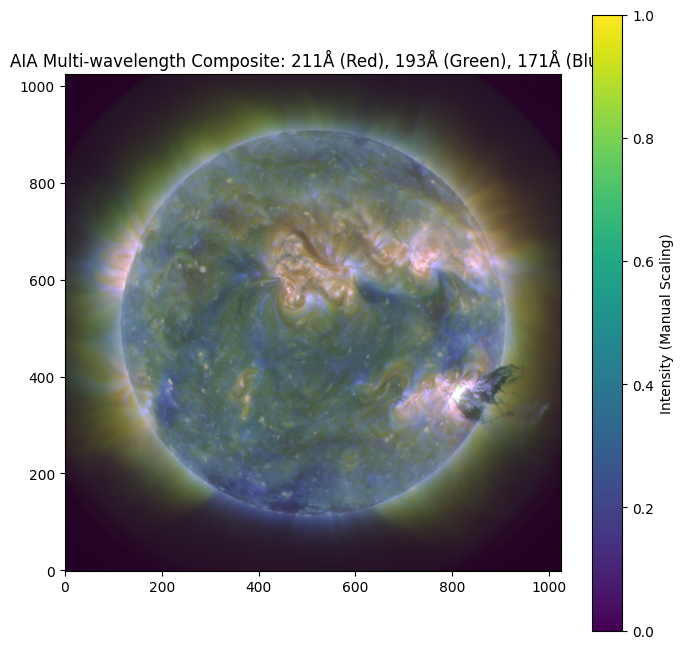

In [10]:
# 各波長の強度スケールを手動で調整
red_channel = normalize(aia_211.data)(aia_211.data) * 1.5
green_channel = normalize(aia_193.data)(aia_193.data) * 1.0
blue_channel = normalize(aia_171.data)(aia_171.data) * 2.0  # 171Å を強調

# RGB画像の作成
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# プロット
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image, origin="lower")
plt.colorbar(label="Intensity (Manual Scaling)")
plt.title("AIA Multi-wavelength Composite: 211Å (Red), 193Å (Green), 171Å (Blue)")
plt.show()


In [13]:
# AIA 171Å の画像を読み込む
aia_map = Map(aia_211)

# 観測日時を取得
obs_time = aia_map.meta["DATE-OBS"]

print(f"AIA 171Å の観測日時: {obs_time}")

AIA 171Å の観測日時: 2011-06-07T06:33:02.58


In [14]:
# 現在の観測日時
print("元の観測日時:", aia_map.meta["DATE-OBS"])

# 観測日時を変更
aia_map.meta["DATE-OBS"] = "2025-01-01T00:00:00.00"

# 変更後の日時を確認
print("変更後の観測日時:", aia_map.meta["DATE-OBS"])

元の観測日時: 2011-06-07T06:33:02.58
変更後の観測日時: 2025-01-01T00:00:00.00


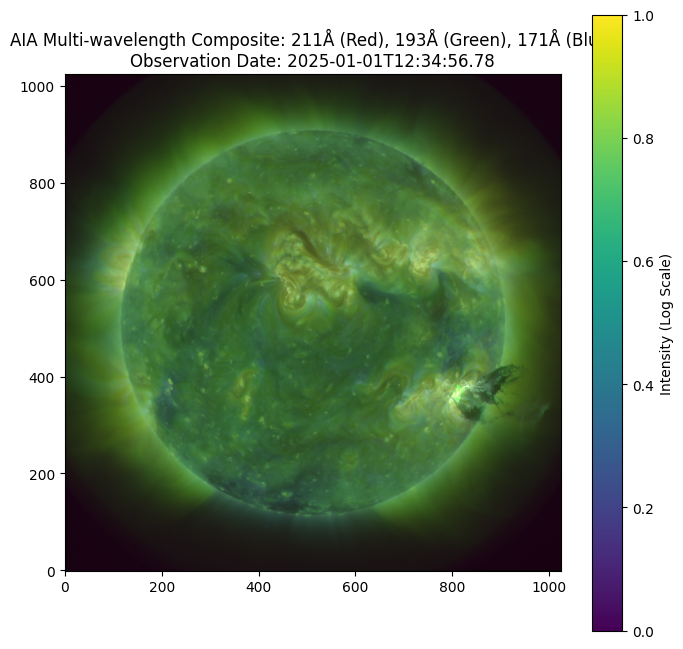

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sunpy.data.sample
from sunpy.map import Map
import astropy.visualization as vis
from matplotlib.colors import LogNorm

# 3つの波長を読み込む
aia_171 = Map(sunpy.data.sample.AIA_171_IMAGE)
aia_193 = Map(sunpy.data.sample.AIA_193_IMAGE)
aia_211 = Map(sunpy.data.sample.AIA_211_IMAGE)

# 🔹 観測日時を変更
new_date_obs = "2025-01-01T12:34:56.78"
aia_171.meta["DATE-OBS"] = new_date_obs
aia_193.meta["DATE-OBS"] = new_date_obs
aia_211.meta["DATE-OBS"] = new_date_obs

# 正規化（対数スケールを使用）
def normalize(data):
    return vis.ImageNormalize(data, stretch=vis.LogStretch())(data)

# 各波長を正規化
red_channel = normalize(aia_211.data)
green_channel = normalize(aia_193.data)
blue_channel = normalize(aia_171.data)

# 🔹 RGB画像の作成 (3D NumPy配列)
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# 🔹 プロット
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image, origin="lower")
plt.colorbar(label="Intensity (Log Scale)")
plt.title(f"AIA Multi-wavelength Composite: 211Å (Red), 193Å (Green), 171Å (Blue)\nObservation Date: {new_date_obs}")
plt.show()


検索結果に含まれる波長: [171.] Angstrom
検索結果に含まれるプロバイダー: Provider
--------
    JSOC
🔍 検索結果: Results from 3 Providers:

100 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Total estimated size: 6.779 Gbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2022-06-13 03:03:09.000 2022-06-13 03:03:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2022-06-13 03:03:21.000 2022-06-13 03:03:22.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 

2025-01-31 19:02:24 - astropy - WARNING: VerifyWarning: Invalid 'BLANK' keyword in header.  The 'BLANK' keyword is only applicable to integer data, and will be ignored in this HDU.


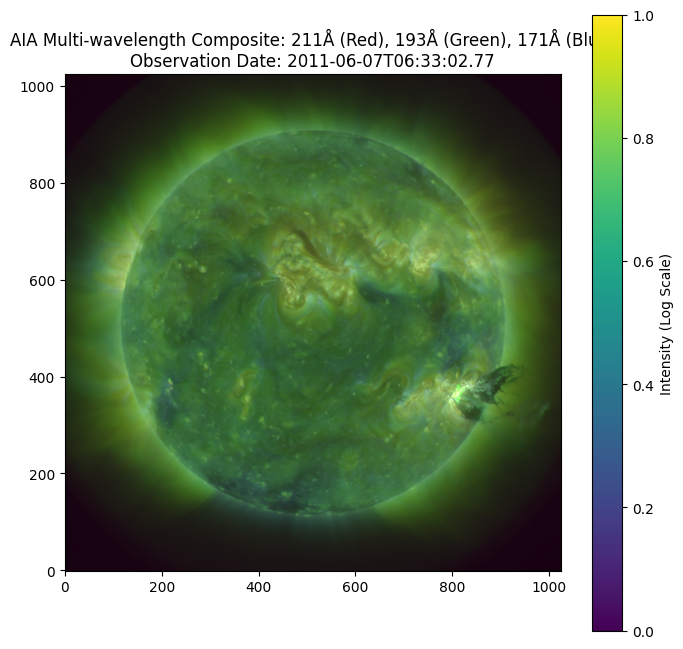

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sunpy.data.sample
from sunpy.net import Fido, attrs as a
from sunpy.map import Map
import astropy.visualization as vis
from astropy import units as u
from astropy.time import Time

# 🔹 取得したい観測日時 (±10分の範囲で探索)
new_date_obs = "2022-06-13T03:13:00.123"  # ミリ秒まで指定
time_range = a.Time("2022-06-13T03:03:00", "2022-06-13T03:23:00")  # ±10分の範囲

# 🔹 Fido を使ってデータを取得（SDOのすべてのプロバイダーを対象に検索）
result = Fido.search(
    time_range,
    a.Instrument("AIA"),
    a.Wavelength(171 * u.angstrom) | a.Wavelength(193 * u.angstrom) | a.Wavelength(211 * u.angstrom),
    a.Source("SDO")  # SDO のすべてのデータを検索
)

# 🔹 検索結果の波長とプロバイダーを表示
unique_wavelengths = np.unique(result[0]["Wavelength"])
unique_providers = np.unique(result[0]["Provider"])
print(f"検索結果に含まれる波長: {unique_wavelengths}")
print(f"検索結果に含まれるプロバイダー: {unique_providers}")

# 🔹 データが見つからなかった場合の処理
if len(result[0]) == 0:
    print("⚠️ 指定した時間帯のデータが見つかりませんでした。時間を変更してください。")
else:
    print("🔍 検索結果:", result)

    # 🔹 各波長ごとに最も近い観測データを取得
    observed_times = Time(result[0]["Start Time"])  # AIA の観測時刻リスト
    target_time = Time(new_date_obs)  # 指定したミリ秒単位の時刻
    
    closest_files = {}  # 各波長のファイルを格納
    wavelengths = np.array(result[0]["Wavelength"])[:, 0].astype(float)  # `2D` → `1D` に変換
    providers = np.array(result[0]["Provider"])  # 各データのプロバイダー
    desired_wavelengths = {171.0: None, 193.0: None, 211.0: None}

    for wavelength in desired_wavelengths.keys():
        # その波長のデータが検索結果に含まれているかチェック
        if wavelength not in unique_wavelengths:
            print(f"⚠️ {wavelength}Å のデータが検索結果に見つかりませんでした。サンプルデータを使用します。")
            continue
        
        # `SDO` のデータを取得（プロバイダーを制限しない）
        mask = np.isclose(wavelengths, wavelength, atol=0.1)
        
        if np.any(mask):  # `True` が含まれているかチェック
            filtered_indices = np.where(mask)[0]  # `True` のインデックスを取得
            filtered_times = observed_times[filtered_indices]  # インデックスを適用

            # 最も近いデータを選択
            closest_index = filtered_indices[np.argmin(np.abs(filtered_times - target_time))]

            # 正しいファイルを取得 (まとめて取得)
            fetched_files = Fido.fetch(result[0][closest_index])
            if len(fetched_files) > 0:
                closest_files[wavelength] = fetched_files[0]
            else:
                print(f"⚠️ {wavelength}Å のデータが見つかりませんでした。サンプルデータを使用します。")
        else:
            print(f"⚠️ {wavelength}Å のデータが見つかりませんでした。サンプルデータを使用します。")

    # 🔹 取得できなかった波長データを `sunpy.data.sample` から取得
    if closest_files.get(171.0) is None:
        print("🔄 171Å のデータをサンプルデータから取得")
        closest_files[171.0] = sunpy.data.sample.AIA_171_IMAGE
    if closest_files.get(193.0) is None:
        print("🔄 193Å のデータをサンプルデータから取得")
        closest_files[193.0] = sunpy.data.sample.AIA_193_IMAGE
    if closest_files.get(211.0) is None:
        print("🔄 211Å のデータをサンプルデータから取得")
        closest_files[211.0] = sunpy.data.sample.AIA_211_IMAGE

    # 🔹 ダウンロードしたファイルを読み込む
    aia_171 = Map(closest_files[171.0])
    aia_193 = Map(closest_files[193.0])
    aia_211 = Map(closest_files[211.0])

    # 🔹 実際の観測時間を取得
    actual_date_obs = aia_171.meta["DATE-OBS"]

    # 🔹 正規化（対数スケールを使用）
    def normalize(data):
        return vis.ImageNormalize(data, stretch=vis.LogStretch())(data)

    # 各波長を正規化
    red_channel = normalize(aia_211.data)
    green_channel = normalize(aia_193.data)
    blue_channel = normalize(aia_171.data)

    # 🔹 RGB画像の作成 (3D NumPy配列)
    rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

    # 🔹 プロット
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image, origin="lower")
    plt.colorbar(label="Intensity (Log Scale)")
    plt.title(f"AIA Multi-wavelength Composite: 211Å (Red), 193Å (Green), 171Å (Blue)\nObservation Date: {actual_date_obs}")
    plt.show()
